### Train a ALM in Google Colab!

### Clone the repository if you don't have it already

In [1]:
import os

if not os.path.isdir('nanoALM'):
    !git clone https://github.com/LWL220184016/nanoVLM_From_Huggingface.git
%cd nanoVLM_From_Huggingface/
!ls

Cloning into 'nanoVLM_From_Huggingface'...
remote: Enumerating objects: 698, done.
remote: Counting objects: 100% (447/447), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 698 (delta 358), reused 284 (delta 260), pack-reused 251 (from 2)
Receiving objects: 100% (698/698), 13.37 MiB | 38.90 MiB/s, done.
Resolving deltas: 100% (444/444), done.
/content/nanoVLM_From_Huggingface
assets			data					  models
benchmark-inference.py	debug_func.py				  nanoALM.ipynb
benchmark_suite.py	debug_tokenizer_dataset_compatibility.py  README.md
compare1.py		generate.py				  train.py
compare2.py		measure_vram.py


### Imports and Setup

In [2]:
# If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install tqdm
!pip -q install huggingface_hub
!pip -q install librosa
!pip install --upgrade datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Foun

In [3]:
# Let's authentificate with the Hugging Face Hub so you can push your model
# from huggingface_hub import notebook_login
# notebook_login()

In [4]:
# Decide on the name of your model here!
# You will need your HF user name and the name you want to give to it
# For me, this would be "lusxvr/nanoALM"
# hf_model_name = "YOUR_HF_USER_NAME/nanoALM"

In [5]:
# nanoALM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import AudioQACollator, SAVEECollator
from data.datasets import SAVEEDataset, AudioQADataset
from data.processors import get_audio_processor
from data.processors import get_tokenizer
from models.audio_language_model import AudioLanguageModel
import models.utils as utils

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets

#Otherwise, the tokenizer will through a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
trained_model = None

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


### Get the dataloaders

In [6]:
def get_dataloaders(train_cfg, alm_cfg):
    # Create datasets
    audio_processor = get_audio_processor(alm_cfg.audio_sample_rate)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # text = "splitting datasets, disable in get_dataloaders function"
    # print(f"\n\033[38;5;05m{text}05m\033[0m")
    # Load and combine all training datasets
    combined_train_data = []
    for dataset_name in train_cfg.train_dataset_name:
        train_ds = load_dataset(
        path = train_cfg.train_dataset_path,
        name = dataset_name,
        # split='train[:1000]'
    )
        combined_train_data.append(train_ds['train'])
    train_ds = concatenate_datasets(combined_train_data)

    test_ds = load_dataset(train_cfg.test_dataset_path)
    train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatinated datasets

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    train_dataset = AudioQADataset(train_ds.select(range(train_size)), tokenizer, audio_processor)
    val_dataset = AudioQADataset(train_ds.select(range(train_size, total_samples)), tokenizer, audio_processor)
    test_dataset = SAVEEDataset(test_ds, tokenizer, audio_processor)

    # Create collators
    aqa_collator = AudioQACollator(tokenizer, alm_cfg.lm_max_length)
    savee_collator = SAVEECollator(tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=train_cfg.savee_batch_size,
        shuffle=False,
        collate_fn=savee_collator,
        pin_memory=True,
        )

    return train_loader, val_loader, test_loader

### Prepare the testing function

In [7]:
def test_savee(model, tokenizer, test_loader, device):
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            audio = batch['audios'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, audio, attention_mask)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)
    accuracy = correct_predictions / total_examples if total_examples > 0 else 0
    return accuracy

### Add debug

In [8]:
# 在训练开始前添加这个检查函数
def debug_model_dimensions(model, input_ids, audio):
    """调试模型各层的维度"""
    print("=== Model Dimension Debug ===")

    # 检查音频编码器
    audio_features = model.audio_encoder(audio)
    print(f"Audio features shape: {audio_features.shape}")

    # 检查模态投影器
    audio_embeds = model.MP(audio_features)
    print(f"Audio embeds shape: {audio_embeds.shape}")

    # 检查文本嵌入
    text_embeds = model.decoder.token_embedding(input_ids)
    print(f"Text embeds shape: {text_embeds.shape}")

    # 检查拼接后的嵌入
    inputs_embeds = torch.cat([audio_embeds, text_embeds], dim=1)
    print(f"Combined embeds shape: {inputs_embeds.shape}")

    # 检查语言模型输出
    logits = model.decoder(inputs_embeds)
    print(f"Logits shape: {logits.shape}")
    print(f"Vocab size (last dim): {logits.shape[-1]}")

    # 检查语言模型配置
    print(f"LM vocab size config: {model.cfg.lm_vocab_size}")
    print(f"Decoder vocab size: {getattr(model.decoder, 'vocab_size', 'Not found')}")

    return logits.shape[-1]

# 在训练循环开始前调用
# vocab_size = debug_model_dimensions(model, input_ids, audios)

In [9]:
def debug_training_step(model, input_ids, audios, attention_mask, labels):
    """调试训练步骤"""
    # 添加这些调试行：
    print(f"Batch debug - input_ids shape: {input_ids.shape}, max: {input_ids.max().item()}")
    print(f"Batch debug - labels shape: {labels.shape}, max: {labels.max().item()}")
    print(f"Batch debug - Model vocab config: {model.cfg.lm_vocab_size}")

    # 检查decoder的实际vocab_size
    if hasattr(model.decoder, 'head') and hasattr(model.decoder.head, 'out_features'):
        print(f"Decoder head in_features: {model.decoder.head.in_features}")
        print(f"Decoder head out_features: {model.decoder.head.out_features}")

### Prepare the training loop

In [ ]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def train(train_cfg, alm_cfg):
    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # Initialize model
    if train_cfg.resume_from_alm_checkpoint:
        model = AudioLanguageModel.from_pretrained(alm_cfg.alm_checkpoint_path)
    else:
        model = AudioLanguageModel(alm_cfg)

    print(f"nanoALM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                    {'params': list(model.decoder.parameters()) + list(model.audio_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # debug_model_dimensions(model, input_ids, audios)  # Debug model dimensions with dummy data
            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()

            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp, len(train_loader) * train_cfg.epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item()
            # 修改音頻token計算：根據實際的音頻處理方式
            audio_tokens = audios.shape[0] * alm_cfg.mp_target_length  # 使用配置的目標長度
            num_tokens += audio_tokens
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 5 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in val_loader:
                        audios = batch["audio"].to(device)
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                            _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_savee(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")
                model.train()

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    if not train_cfg.eval_in_epochs:
        model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
    try:
        model.push_to_hub(hf_model_name)
    except Exception as e:
        print(f"Error pushing model to hub: {e}")

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

    # With this code you can test the accuracy of the model on the SAVEE dataset
    # But if you only train with few samples, the accuracy will be very low
    # print("Testing SAVEE Accuracy:")
    # accuracy = test_savee(model, tokenizer, test_loader, device)
    # print(f"SAVEE Accuracy: {accuracy:.4f}")

### Prepare the Configs
Instead of using the config.py file in the repo (which was created to run on one H100), we will create our config here to play around with the parameters easier and adapt them to colabs capabilities

In [11]:
@dataclass
class ALMConfig:
    audio_hidden_dim: int = 768
    audio_inter_dim: int = 4 * audio_hidden_dim
    audio_patch_size: int = 16  # 音频patch大小（时间步数）
    audio_n_heads: int = 12
    audio_dropout: float = 0.0
    audio_n_blocks: int = 12
    audio_ln_eps: float = 1e-6
    audio_model_type: str = 'custom_audio_transformer'

    # 音频处理相关参数
    audio_sample_rate: int = 16000  # 采样率
    audio_n_fft: int = 400  # FFT窗口大小
    audio_hop_length: int = 160  # 跳跃长度
    audio_n_mels: int = 80  # 梅尔滤波器数量
    audio_max_length: int = 1000  # 最大时间步数

    lm_hidden_dim: int = 576
    lm_inter_dim: int = 1536
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_vocab_size: int = 49152
    lm_n_heads: int = 9
    lm_n_kv_heads: int = 3
    lm_dropout: float = 0.0
    lm_n_blocks: int = 30
    lm_attn_scaling: float = 1.0
    lm_eos_token_id: int = 0
    lm_use_tokens: bool = False
    lm_tie_weights: bool = True
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M'
    lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'

    # 模態投影器配置
    mp_projection_type: str = 'adaptive_pool'
    mp_target_length: int = 50
    mp_use_position_aware: bool = True

    # 計算語言模型最大長度
    lm_max_length: int = 128 - 50  # 總長度 - 音頻token長度

    # ALM特定配置
    alm_load_backbone_weights: bool = True
    alm_checkpoint_path: str = 'checkpoints'
    alm_name: str = 'nanoALM-222M'


@dataclass
class TrainConfig:
    lr_mp: float = 1e-3
    lr_backbones: float = 5e-5
    val_ratio: float = 0.2
    compile: bool = False
    data_cutoff_idx: int = 1024 # Let's only use a small subset of the data at first, otherwise it takes very long to see anything :D
    batch_size: int = 12
    savee_batch_size: int = 12
    epochs: int = 20
    eval_in_epochs: bool = False # Deactivating this in colab, because it would evaluate 1500 samples of SAVEE every time otherwise
    resume_from_alm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole ALM or you want to start from scratch

    # train_dataset_path: str = 'AbstractTTS/IEMOCAP'
    # train_dataset_name: tuple[str, ...] = ('default', ) #All options; ("ai2d", "aokvqa", "chart2text", "chartqa", "clevr", "cocoqa", "datikz", "diagram_image_to_text", "docvqa", "dvqa", "figureqa", "finqa", "geomverse", "hateful_memes", "hitab", "iam", "iconqa", "infographic_vqa", "intergps", "localized_narratives", "mapqa", "multihiertt", "ocrvqa", "plotqa", "raven", "rendered_text", "robut_sqa", "robut_wikisql", "robut_wtq", "scienceqa", "screen2words", "st_vqa", "tabmwp", "tallyqa", "tat_qa", "textcaps", "textvqa", "tqa", "vistext", "visual7w", "visualmrc", "vqarad", "vqav2", "vsr", "websight") # "clevr_math", "okvqa", "spot_the_diff", "nlvr2", "mimic_cgd",

    # train_dataset_path: str = 'speechbrain/LoquaciousSet'
    # train_dataset_name: tuple[str, ...] = ('medium', ) # small, medium

    train_dataset_path: str = 'MLCommons/peoples_speech'
    train_dataset_name: tuple[str, ...] = ('clean_sa', ) # small, medium
    test_dataset_path: str = "AbstractTTS/SAVEE"

### Lets run the training!

In [12]:
import os
# 要創建的目錄路徑
dir_name = ALMConfig.alm_checkpoint_path

try:
    os.mkdir(dir_name)
    print(f"Directory '{dir_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{dir_name}' already exists.")
except FileNotFoundError:
    print(f"Parent directory does not exist for '{dir_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory 'checkpoints' created successfully.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/489 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/804 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/151 [00:00<?, ?it/s]

train-00000-of-00151.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

train-00001-of-00151.parquet:   0%|          | 0.00/509M [00:00<?, ?B/s]

train-00002-of-00151.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00003-of-00151.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

train-00004-of-00151.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

train-00005-of-00151.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00006-of-00151.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00007-of-00151.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

train-00008-of-00151.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00009-of-00151.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

train-00010-of-00151.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

train-00011-of-00151.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00012-of-00151.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

train-00013-of-00151.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00014-of-00151.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

train-00015-of-00151.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

train-00016-of-00151.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

train-00017-of-00151.parquet:   0%|          | 0.00/528M [00:00<?, ?B/s]

train-00018-of-00151.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

train-00019-of-00151.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00020-of-00151.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00021-of-00151.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00022-of-00151.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00023-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00024-of-00151.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00025-of-00151.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00026-of-00151.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00027-of-00151.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00028-of-00151.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

train-00029-of-00151.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

train-00030-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00031-of-00151.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

train-00032-of-00151.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00033-of-00151.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

train-00034-of-00151.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

train-00035-of-00151.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

train-00036-of-00151.parquet:   0%|          | 0.00/514M [00:00<?, ?B/s]

train-00037-of-00151.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

train-00038-of-00151.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

train-00039-of-00151.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00040-of-00151.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

train-00041-of-00151.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

train-00042-of-00151.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00043-of-00151.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00044-of-00151.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00045-of-00151.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

train-00046-of-00151.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

train-00047-of-00151.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

train-00048-of-00151.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00049-of-00151.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

train-00050-of-00151.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00051-of-00151.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00052-of-00151.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00053-of-00151.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00054-of-00151.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

train-00055-of-00151.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

train-00056-of-00151.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

train-00057-of-00151.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

train-00058-of-00151.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00059-of-00151.parquet:   0%|          | 0.00/411M [00:00<?, ?B/s]

train-00060-of-00151.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

train-00061-of-00151.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00062-of-00151.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00063-of-00151.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00064-of-00151.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00065-of-00151.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00066-of-00151.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00067-of-00151.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00068-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00069-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00070-of-00151.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

train-00071-of-00151.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00072-of-00151.parquet:   0%|          | 0.00/371M [00:00<?, ?B/s]

train-00073-of-00151.parquet:   0%|          | 0.00/430M [00:00<?, ?B/s]

train-00074-of-00151.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

train-00075-of-00151.parquet:   0%|          | 0.00/430M [00:00<?, ?B/s]

train-00076-of-00151.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00077-of-00151.parquet:   0%|          | 0.00/414M [00:00<?, ?B/s]

train-00078-of-00151.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00079-of-00151.parquet:   0%|          | 0.00/387M [00:00<?, ?B/s]

train-00080-of-00151.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00081-of-00151.parquet:   0%|          | 0.00/414M [00:00<?, ?B/s]

train-00082-of-00151.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00083-of-00151.parquet:   0%|          | 0.00/433M [00:00<?, ?B/s]

train-00084-of-00151.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

train-00085-of-00151.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

train-00086-of-00151.parquet:   0%|          | 0.00/430M [00:00<?, ?B/s]

train-00087-of-00151.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00088-of-00151.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00089-of-00151.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

train-00090-of-00151.parquet:   0%|          | 0.00/435M [00:00<?, ?B/s]

train-00091-of-00151.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

train-00092-of-00151.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

train-00093-of-00151.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

train-00094-of-00151.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

train-00095-of-00151.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

train-00096-of-00151.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00097-of-00151.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

train-00098-of-00151.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00099-of-00151.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00100-of-00151.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

train-00101-of-00151.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

train-00102-of-00151.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

train-00103-of-00151.parquet:   0%|          | 0.00/449M [00:00<?, ?B/s]

train-00104-of-00151.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00105-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00106-of-00151.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00107-of-00151.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00108-of-00151.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

train-00109-of-00151.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00110-of-00151.parquet:   0%|          | 0.00/439M [00:00<?, ?B/s]

train-00111-of-00151.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

train-00112-of-00151.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00113-of-00151.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00114-of-00151.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

train-00115-of-00151.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00116-of-00151.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

train-00117-of-00151.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00118-of-00151.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

train-00119-of-00151.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

train-00120-of-00151.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00121-of-00151.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00122-of-00151.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

train-00123-of-00151.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

train-00124-of-00151.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00125-of-00151.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00126-of-00151.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00127-of-00151.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00128-of-00151.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

train-00129-of-00151.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00130-of-00151.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

train-00131-of-00151.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

train-00132-of-00151.parquet:   0%|          | 0.00/435M [00:00<?, ?B/s]

train-00133-of-00151.parquet:   0%|          | 0.00/422M [00:00<?, ?B/s]

train-00134-of-00151.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00135-of-00151.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

train-00136-of-00151.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

train-00137-of-00151.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

train-00138-of-00151.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

train-00139-of-00151.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00140-of-00151.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00141-of-00151.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00142-of-00151.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00143-of-00151.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

train-00144-of-00151.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00145-of-00151.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

train-00146-of-00151.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

train-00147-of-00151.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00148-of-00151.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

train-00149-of-00151.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00150-of-00151.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

validation-00000-of-00005.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

validation-00001-of-00005.parquet:   0%|          | 0.00/530M [00:00<?, ?B/s]

validation-00002-of-00005.parquet:   0%|          | 0.00/367M [00:00<?, ?B/s]

validation-00003-of-00005.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

validation-00004-of-00005.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

test-00000-of-00008.parquet:   0%|          | 0.00/460M [00:00<?, ?B/s]

test-00001-of-00008.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

test-00002-of-00008.parquet:   0%|          | 0.00/564M [00:00<?, ?B/s]

test-00003-of-00008.parquet:   0%|          | 0.00/557M [00:00<?, ?B/s]

test-00004-of-00008.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

test-00005-of-00008.parquet:   0%|          | 0.00/593M [00:00<?, ?B/s]

test-00006-of-00008.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

test-00007-of-00008.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/257093 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/34898 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/133 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/622 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/480 [00:00<?, ? examples/s]

Loading from backbone weights
Initializing AudioTransformer from scratch with custom_audio_transformer
AudioTransformer initialized with 86,087,424 parameters.


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

Successfully loaded HuggingFaceTB/SmolLM2-135M weights from safetensors. Model has 134,515,008 parameters.
nanoALM initialized with 221,044,800 parameters
Training summary: 820 samples, 68 batches/epoch, batch size 12


100%|██████████| 68/68 [01:49<00:00,  1.61s/it]


Epoch 1/20 | Train Loss: 4.4963 | Val Loss: 3.8037 | Time: 109.71s | T/s: 677.29


100%|██████████| 68/68 [01:36<00:00,  1.41s/it]


Epoch 2/20 | Train Loss: 3.6659 | Val Loss: 3.6779 | Time: 96.12s | T/s: 772.38


100%|██████████| 68/68 [01:31<00:00,  1.35s/it]


Epoch 3/20 | Train Loss: 3.4953 | Val Loss: 3.5368 | Time: 91.60s | T/s: 811.04


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


Epoch 4/20 | Train Loss: 3.3780 | Val Loss: 3.5289 | Time: 95.22s | T/s: 780.20


100%|██████████| 68/68 [01:30<00:00,  1.33s/it]


Epoch 5/20 | Train Loss: 3.2654 | Val Loss: 3.4354 | Time: 90.69s | T/s: 819.51


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


Epoch 6/20 | Train Loss: 3.1387 | Val Loss: 3.4049 | Time: 95.94s | T/s: 773.91


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


Epoch 7/20 | Train Loss: 3.0344 | Val Loss: 3.3906 | Time: 94.44s | T/s: 786.18


100%|██████████| 68/68 [01:31<00:00,  1.35s/it]


Epoch 8/20 | Train Loss: 2.9302 | Val Loss: 3.3848 | Time: 91.53s | T/s: 811.59


100%|██████████| 68/68 [01:37<00:00,  1.43s/it]


Epoch 9/20 | Train Loss: 2.8148 | Val Loss: 3.3928 | Time: 97.57s | T/s: 761.23


100%|██████████| 68/68 [01:30<00:00,  1.33s/it]


Epoch 10/20 | Train Loss: 2.6998 | Val Loss: 3.4709 | Time: 90.78s | T/s: 818.57


100%|██████████| 68/68 [01:35<00:00,  1.40s/it]


Epoch 11/20 | Train Loss: 2.6692 | Val Loss: 3.4566 | Time: 95.26s | T/s: 780.00


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


Epoch 12/20 | Train Loss: 2.5157 | Val Loss: 3.5140 | Time: 94.57s | T/s: 785.74


100%|██████████| 68/68 [01:29<00:00,  1.32s/it]


Epoch 13/20 | Train Loss: 2.3482 | Val Loss: 3.5744 | Time: 89.72s | T/s: 827.88


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


Epoch 14/20 | Train Loss: 2.1985 | Val Loss: 3.6971 | Time: 94.30s | T/s: 788.08


100%|██████████| 68/68 [01:28<00:00,  1.30s/it]


Epoch 15/20 | Train Loss: 2.0466 | Val Loss: 3.8004 | Time: 88.29s | T/s: 841.58


100%|██████████| 68/68 [01:34<00:00,  1.38s/it]


Epoch 16/20 | Train Loss: 1.9059 | Val Loss: 3.8984 | Time: 94.06s | T/s: 789.57


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


Epoch 17/20 | Train Loss: 1.7838 | Val Loss: 4.0180 | Time: 93.31s | T/s: 795.90


100%|██████████| 68/68 [01:30<00:00,  1.33s/it]


Epoch 18/20 | Train Loss: 1.6845 | Val Loss: 4.0716 | Time: 90.62s | T/s: 819.50


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


Epoch 19/20 | Train Loss: 1.6048 | Val Loss: 4.1681 | Time: 95.74s | T/s: 775.94


100%|██████████| 68/68 [01:32<00:00,  1.36s/it]


Epoch 20/20 | Train Loss: 1.5340 | Val Loss: 4.2398 | Time: 92.42s | T/s: 803.71
Error pushing model to hub: 'AudioLanguageModel' object has no attribute 'push_to_hub'
Average time per epoch: 94.09s
Average time per sample: 0.1147s


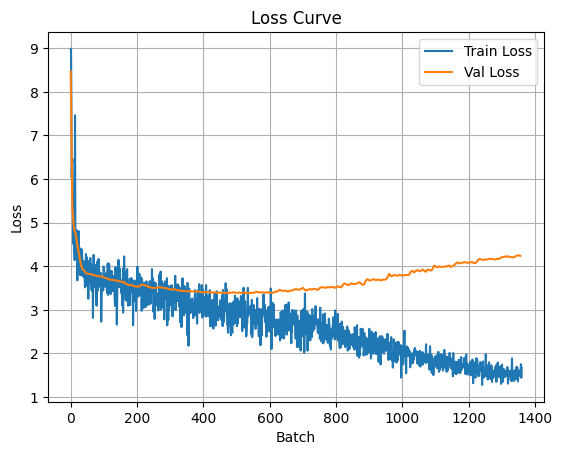

In [ ]:
alm_cfg = ALMConfig()
train_cfg = TrainConfig()
trained_model = train(train_cfg, alm_cfg)

As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it

In [ ]:
trained_model.save_pretrained("/content/")

AttributeError: 'NoneType' object has no attribute 'save_pretrained'